In [1]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import importlib
import torch

import FullRankRNN as rnn
import Reinforce as rln

In [38]:
scaling_factors = np.linspace(0.1, 1, 10)

for i, scaling_factor in enumerate(scaling_factors):
    
    reinforce = rln.REINFORCE(train_wi=False, train_wrec=False, name_load="models/FullRankRNN.pt")
    
    #print(reinforce.actor_network.wo)
    reinforce.actor_network.wo.data *= scaling_factor
    #print(reinforce.actor_network.wo)
    
    obs, rewards, actions, probs, log_probs, values, \
    trial_begins, gt, wrong_on_avarage = reinforce.experience(100)
    
    print(i+1,": The percentage of uncorrect answers with a scaling factor of %.1f is %i%%" %(scaling_factor, wrong_on_avarage*100))

1 : The percentage of uncorrect answers with a scaling factor of 0.1 is 45%
2 : The percentage of uncorrect answers with a scaling factor of 0.2 is 44%
3 : The percentage of uncorrect answers with a scaling factor of 0.3 is 28%
4 : The percentage of uncorrect answers with a scaling factor of 0.4 is 38%
5 : The percentage of uncorrect answers with a scaling factor of 0.5 is 28%
6 : The percentage of uncorrect answers with a scaling factor of 0.6 is 28%
7 : The percentage of uncorrect answers with a scaling factor of 0.7 is 24%
8 : The percentage of uncorrect answers with a scaling factor of 0.8 is 25%
9 : The percentage of uncorrect answers with a scaling factor of 0.9 is 21%
10 : The percentage of uncorrect answers with a scaling factor of 1.0 is 20%


In [5]:
#torch.autograd.set_detect_anomaly(True)
importlib.reload(rln)
reinforce = rln.REINFORCE(name_load="models/FullRankRNN.pt", train_wi_a=False, train_wrec_a=False)
reinforce.actor_network.wo.data *= 0.4
iterations = 1
actor_losses, critic_losses, wrong_on_avarage = reinforce.training(n_trs=10, iterations=iterations)

It took 5.54 s for 1 iterations

It took 5.54 s on average for each 10-trails iteration



In [3]:
plt.figure(figsize=(25,5))

length = np.linspace(0,iterations-1,iterations)
fit = np.polyfit(length, actor_losses, 1)
fit3 = np.polyfit(length, wrong_on_avarage, 1)

plt.plot(length, actor_losses, "-o", label="actor losses")
plt.plot(length, fit[1]+length*fit[0], "-o", label="fit")
plt.plot(length, wrong_on_avarage, "-o", label="mistakes")
plt.plot(length, fit3[1]+length*fit3[0], "-o", label="fit", color="lime")
plt.axhline(actor_losses.mean(), color="red")
plt.xticks(size=20)
plt.yticks(size=20)
plt.legend(fontsize=20, loc="upper left");


plt.figure(figsize=(25,5))

length = np.linspace(0,iterations-1,iterations)
fit2 = np.polyfit(length, critic_losses, 1)


plt.plot(length, critic_losses, "-o", label="critic losses")
plt.plot(length, fit2[1]+length*fit2[0], "-o", label="fit")
plt.plot(length, wrong_on_avarage, "-o", label="mistakes")
plt.plot(length, fit3[1]+length*fit3[0], "-o", label="fit", color="lime")
#plt.axhline(actor_losses.mean(), color="red")
plt.xticks(size=20)
plt.yticks(size=20)
plt.legend(fontsize=20, loc="upper left");

/home/martina/anaconda3/lib/python3.8/site-packages/numpy/lib/polynomial.py:667: RuntimeWarning: invalid value encountered in divide
  lhs /= scale


SystemError: <class 'numpy.linalg.LinAlgError'> returned a result with an error set

<Figure size 1800x360 with 0 Axes>

In [3]:
importlib.reload(rln)
reinforce = rln.REINFORCE()
iterations = 20
actor_losses, critic_losses, wrong_on_avarage = reinforce.training(n_trs=10, iterations=iterations)

It took 100.43 s for 20 iterations

It took 4.89 s on average for each 10-trails iteration



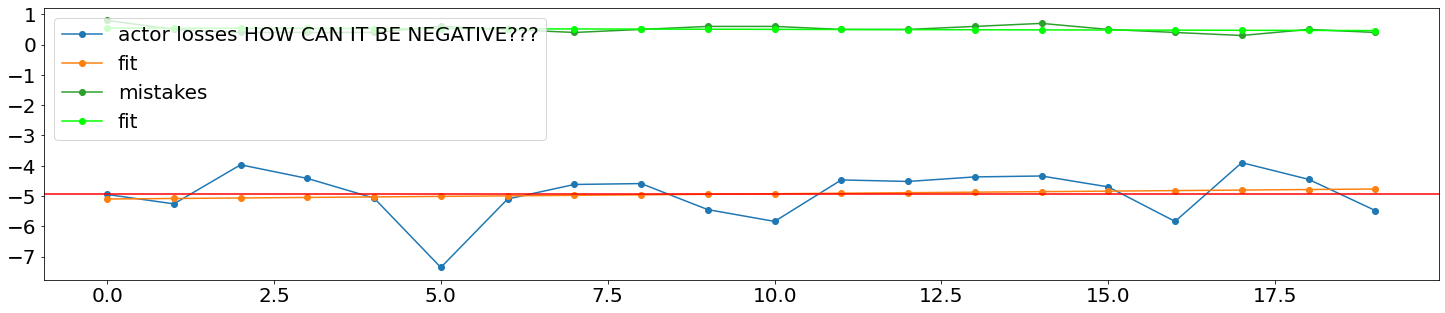

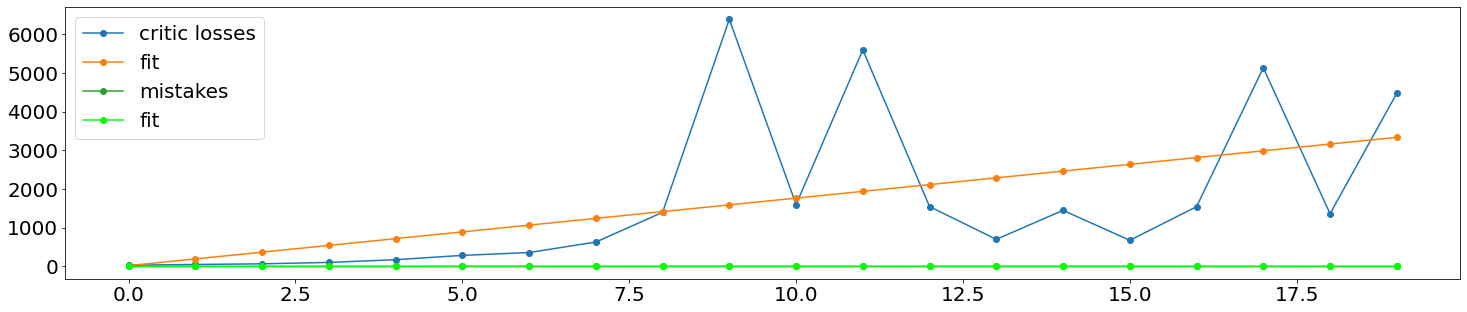

In [6]:
plt.figure(figsize=(25,5))

length = np.linspace(0,iterations-1,iterations)
fit = np.polyfit(length, actor_losses, 1)
fit3 = np.polyfit(length, wrong_on_avarage, 1)

plt.plot(length, actor_losses, "-o", label="actor losses HOW CAN IT BE NEGATIVE???")
plt.plot(length, fit[1]+length*fit[0], "-o", label="fit")
plt.plot(length, wrong_on_avarage, "-o", label="mistakes")
plt.plot(length, fit3[1]+length*fit3[0], "-o", label="fit", color="lime")
plt.axhline(actor_losses.mean(), color="red")
plt.xticks(size=20)
plt.yticks(size=20)
plt.legend(fontsize=20, loc="upper left");


plt.figure(figsize=(25,5))

length = np.linspace(0,iterations-1,iterations)
fit2 = np.polyfit(length, critic_losses, 1)


plt.plot(length, critic_losses, "-o", label="critic losses")
plt.plot(length, fit2[1]+length*fit2[0], "-o", label="fit")
plt.plot(length, wrong_on_avarage, "-o", label="mistakes")
plt.plot(length, fit3[1]+length*fit3[0], "-o", label="fit", color="lime")
#plt.axhline(actor_losses.mean(), color="red")
plt.xticks(size=20)
plt.yticks(size=20)
plt.legend(fontsize=20, loc="upper left");

In [5]:
obs, rewards, actions, probs, log_probs, values, trial_begins, gt = reinforce.experience(10)

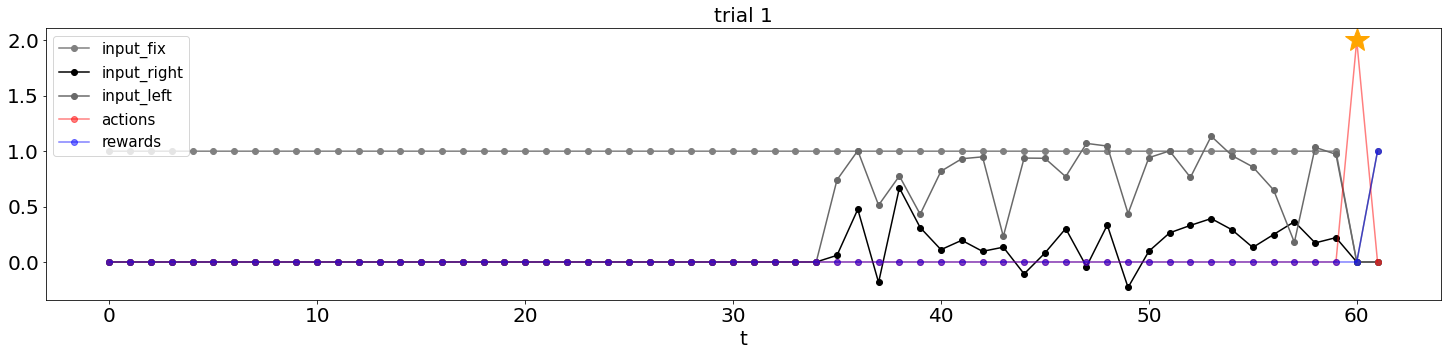

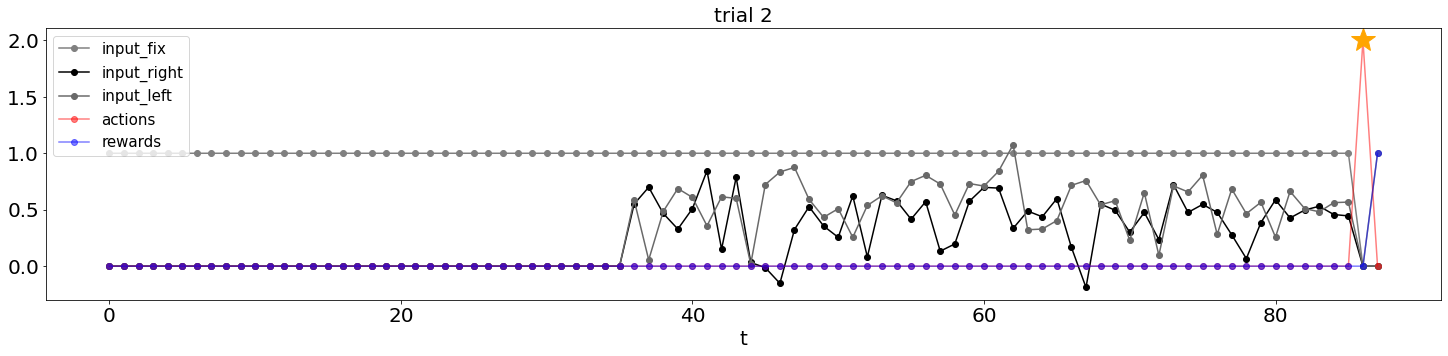

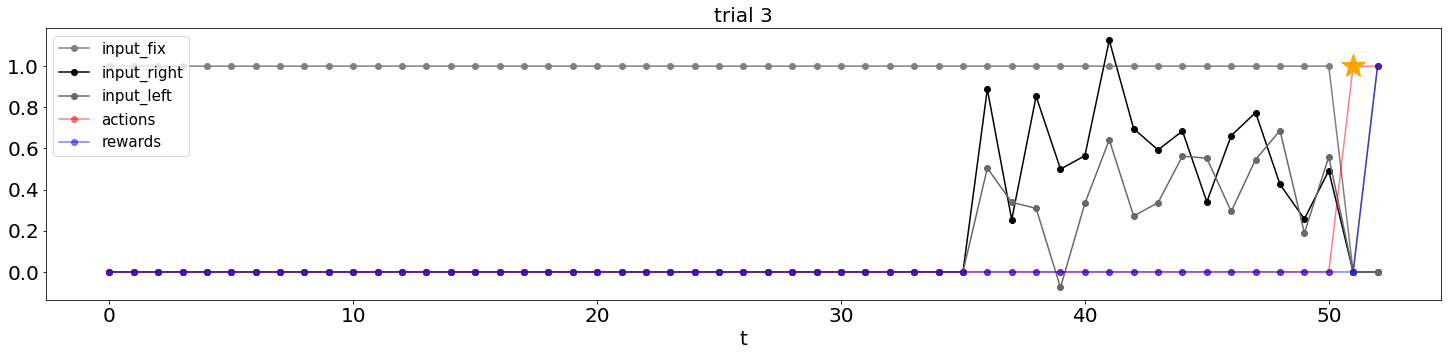

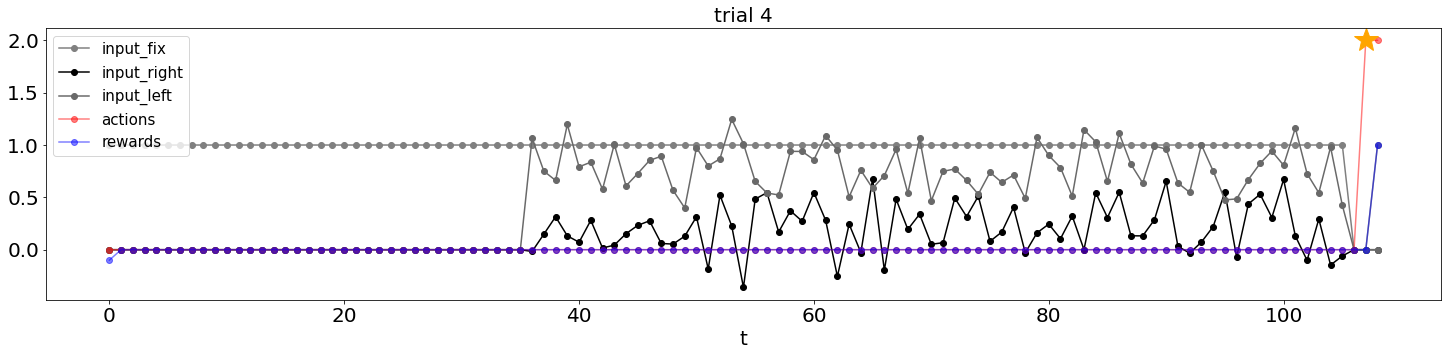

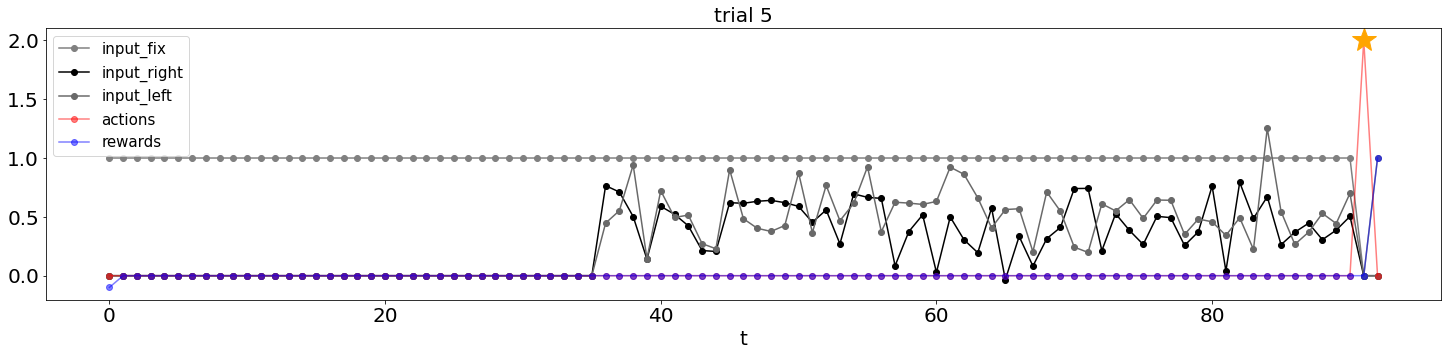

In [10]:
obs = obs.T
length = 0
for i in range(5):

    plt.figure(figsize=(25,5))
    
    start = int(trial_begins[i])
    stop = int(trial_begins[i+1])
     
    plt.plot(obs[0][start:stop], "-o", label="input_fix", color="gray")
    plt.plot(obs[1][start:stop], "-o", label="input_right", color="black")
    plt.plot(obs[2][start:stop], "-o", label="input_left", color="dimgray")
    plt.plot(actions[start:stop], "-o", label="actions", color="red", alpha=0.5)
    plt.plot(rewards[start:stop], "-o", label="rewards", color="blue", alpha=0.5)
    plt.plot(stop-length-2, gt[i], "*", markersize=25, color="orange")
    length += len(obs[0][start:stop])

    plt.xlabel("t", size=20)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.title("trial %i" %(i+1), size=20)
    plt.legend(fontsize=15, loc="upper left");